# Exercise 6
Johannes Kammerer, Zhao Sun, Tong Yu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.sparse import coo_matrix, csc_matrix, vstack
from scipy.sparse.linalg import lsqr
import os
from scipy.ndimage.filters import gaussian_filter

## 3 Denoising of a CT image

In [3]:
def construct_X(M, alphas, Np=None, tau = 0):
    if Np == None:
        Np = int(np.ceil(math.sqrt(2) * M))
    if Np%2 == 0:
        Np = Np + 1 #Choosing an odd number of sensor elements
        
    # specify the expected shape of output matrix
    N = int(Np*len(alphas))
    D = int(M*M)
    
    # set up containers for sparse matrix parameters
    weights = np.empty((0,))
    i_indices = np.empty((0,),int)
    j_indices = np.empty((0,),int)
    
    # create an array C to hold the coordinates of the tomogram's pixel centers
    C = np.zeros((2,D))    
    
    # set the origin of the new coordinates at the center of img
    # transform the origin of the first pixel in the original img into new coordinates
    a0 = -(M/2 - 0.5)
    b0 =  -(M/2 - 0.5)
        
    # vectorized implemenation of centers of all pixels
    y,x = np.mgrid[0:M,0:M]
    ja = x.reshape(-1)
    jb = y.reshape(-1)
    
    j = ja + jb*M    # effectively same as np.arange(D)
    
    # re-express the centers of all img pixels in new coordinates
    C[0,:] =  ja + a0
    C[1,:] =  jb + b0
  
    # distance from first sensor element center to the origin in the new coordinates system
    s0 = (Np-1)/2
    
    # unit vector along the rotated sensor projection of each pixel onto the sensor: p = np.dot(n.T,C)
    
    for k in range(len(alphas)):
        rad = np.radians(alphas[k])   # convert degree to radian
        
        n = np.array([math.cos(rad), -math.sin(rad)])  # rotation matrix for projection onto new axis
        p = np.dot(n.T,C) + s0
                
        w0 = np.ceil(p) - p         # vector size D, weight allocated to proceeding integer
        i0 = np.floor(p) + k*Np     # vector size D, i = ip + Np*io
        j0 = j                      # vector size D, j = ja + M*jb
        
        w1 = p - np.floor(p)
        i1 = i0+1
        j1 = j
        
        weights = np.concatenate([weights,w0,w1])
        i_indices = np.concatenate([i_indices,i0,i1])
        j_indices = np.concatenate([j_indices,j0,j1])
    
    X = (coo_matrix((weights, (i_indices.astype(int), j_indices.astype(int))), shape=(N, D), dtype = np.float32))  
    
#     X_0 = X.toarray()   
#     print(X_0.shape)
    
    if tau > 0:
        A = np.diag(np.full(D, math.sqrt(tau)))
#         print(A.shape)
        X = vstack([X, A])
    return X


In [11]:
os.chdir('/Users/jocelyn/Desktop/fundamentals of ML/Exercise5')
alphas = np.load('hs_tomography/alphas_195.npy')
Y = np.load('hs_tomography/y_195.npy')
M = 195
Np = 275 #set sensor size 275
D = M*M
tau = [0,1,10,100,1000,10000]
Y_tau = np.hstack([Y, np.zeros(D)])
# print(Y_tau.shape)
# print(alphas.shape)
# print(Y.shape, D)

### Ridge regression

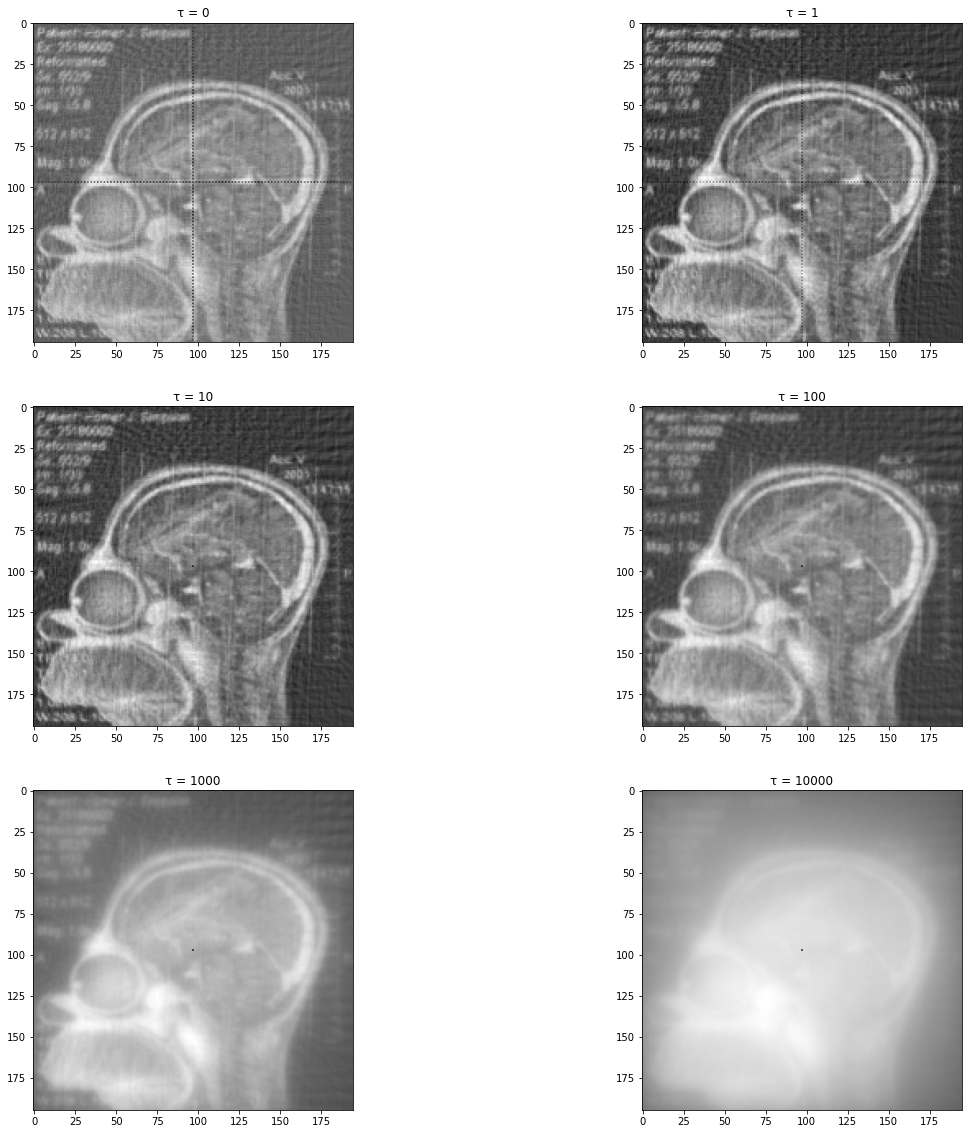

In [208]:
#Reconstruct the tomogram for 64 angles with different τ
plt.subplots(3,2, figsize = (20,20))
plt.gray()
plt.axis("off")

step = len(alphas)/64  #evenly select the indices according the step
index = [int((step-1) + j *step) for j in range(64)]
alphas_new = alphas[index]
Y_0 = np.array([Y[Np*m : Np*(m+1)] for m in index]).flatten()
# print(Y_0.shape)
Y_tau = np.hstack([Y_0, np.zeros(D)])
# print(Y_tau.shape)
for i in range(len(tau)):
    if tau[i]==0: 
        Y = Y_0
    else:
        Y = Y_tau
    X = construct_X(M, alphas_new, Np, tau[i]).tocsc()
    beta = lsqr(X,Y,atol = 1e-5, btol = 1e-5)[0].reshape(195,195)
    plt.subplot(3,2,i+1)
    plt.imshow(beta)
    plt.title("τ = {}".format(tau[i]))

plt.show()
         

The best compromise of image sharpness and noise might be when τ = 10.

### Gaussian filtering

In [211]:
Y = Y_0
X = construct_X(M, alphas_new, Np, tau = 0).tocsc()
beta = lsqr(X,Y,atol = 1e-5, btol = 1e-5)[0].reshape(195,195)

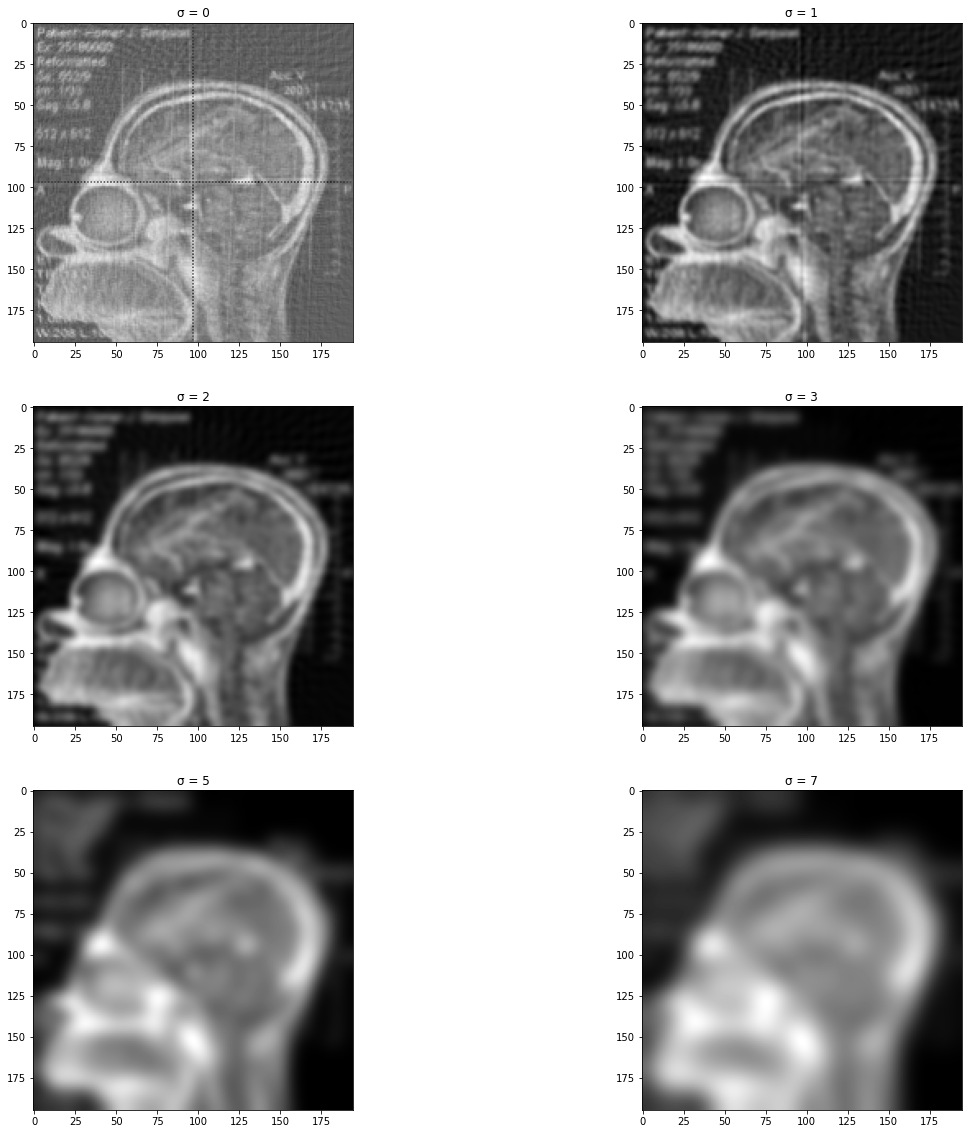

In [218]:
sigma = [0,1,2,3,5,7]

plt.subplots(3,2, figsize = (20,20))
plt.gray()
plt.axis("off")
for i in range(len(sigma)):
    beta_g = gaussian_filter(beta, sigma[i])
    
    plt.subplot(3,2,i+1)
    plt.imshow(beta_g)
    plt.title("σ = {}".format(sigma[i]))
plt.show()    

### Similarities and difference between ridge regression and Gaussian filtering:
Similarities: with the increasement of τ and σ, the noise level will become higher and higher.

Difference: Gaussian filtering's noise level increases very quickly with the increasement of σ; when σ = 2, the tomogram is already very blurry. While the Ridge regression's noise level increases slowly as τ increases. When τ = 100. the tomogram is still clear and easy to observe the strange part in the head of patient H.S.

## 4 Automatic feature selection
## 4.1 Implement Orthogonal Matching Pursuit

In [4]:
def omp_regression(X, y, T):
    """
    Input: X: N*D
           y: N
           T: >0, the desired number of non-zero elements in the final solution beta
    Return: beta: matrix(D*T)
    """
    #Initialization
    A = []
    D = X.shape[1]
    B = [i for i in range(D)]
    r = y
    beta = np.zeros((D,T))
    
    #Iteration
    for i in range(T):
        j = np.argmax([np.abs(np.dot(X[:,j].T, r)) for j in B])
        A.append(B.pop(j))
        X_active = X[: ,A]
        beta0 = np.linalg.lstsq(X_active, y, rcond=None)[0]
        r = y - np.dot(X_active, beta0)
        beta[A, i] = beta0
        
    return beta

## 4.2 Classification with sparse LDA

In [5]:
from sklearn.datasets import load_digits
from sklearn import model_selection

In [6]:
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# Filter out digits 1 and 7 from data set.
target17 = np.hstack([target[target == 1],target[target == 7]])
data17 = np.vstack([data[target == 1], data[target == 7]])

target17[target17 == 1] = 1
target17[target17 == 7] = -1

# Separate the data into a training and a test set.
X_train, X_test, y_train, y_test = model_selection.train_test_split(data17, target17, test_size = 0.2, random_state = 0)
print("Training set :", X_train.shape, "\nTest set: ", X_test.shape)
print("Training responses:", y_train.shape, "\nTest responses:", y_test.shape)

# Standardize data
X_train_s = (X_train - X_train.mean(axis = 0))/(X_train.std(axis = 0)+ 1e-100)
X_test_s = (X_test - X_test.mean(axis = 0))/(X_test.std(axis = 0)+ 1e-100)
# print(X_train_s.shape, X_test_s.shape)

Training set : (288, 64) 
Test set:  (73, 64)
Training responses: (288,) 
Test responses: (73,)


In [7]:
#choose T = 64
T = 64
beta = omp_regression(X_train, y_train,T)
beta_s =  omp_regression(X_train_s, y_train,T)
print(beta.shape)

(64, 64)


In [8]:
def pre_error(beta, X, y):
    """
    Input: beta: beta_hat from previous orthogonal matching pursuit regression
           X: test data of 'digits' set
           y: response of 'digits' set
    Return: error rate
    """ 
    errors = []
    for t in range(T):
        pre = np.dot(X, beta[:,t])
        pre[np.where(pre < 0)] = -1
        pre[np.where(pre > 0)] = 1
#         print(pre.shape)
        error = (np.sum(pre!=y)/len(y))*100
        errors.append(error)
    return errors

In [9]:
error_beta = pre_error(beta, X_test, y_test)
error_beta_s = pre_error(beta_s, X_test_s, y_test)
# print(len(error_beta))

Error rate/t =,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
data_non-standardized,49.315%,2.740%,2.740%,2.740%,1.370%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%
data_standardized,2.740%,2.740%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%,0.000%


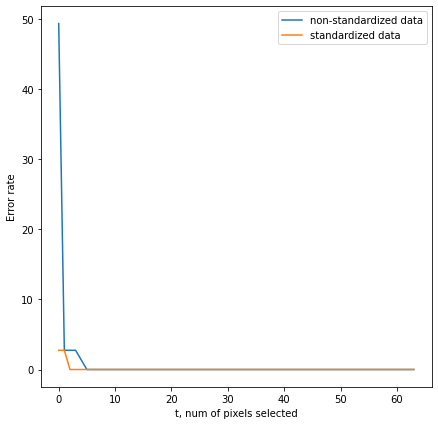

In [11]:
###Analyze the error
# display as Pandas DataFrames
display(pd.DataFrame(
             data = np.vstack([error_beta, error_beta_s]),
             index = ['data_non-standardized','data_standardized'],
             columns = [i+1 for i in range(T)])
              .rename_axis('Error rate/t =', axis ='columns')
             .style.format('{0:.3f}%')    
       )
# display as a plot
plt.figure(figsize = (7,7))
plt.plot(error_beta, label = 'non-standardized data')
plt.plot(error_beta_s, label = 'standardized data')
plt.legend()
plt.xlabel('t, num of pixels selected')
plt.ylabel('Error rate')
plt.show()

- From the analyzation above, it is beneficial to standardize the data before training.
- For standardized data, when t is no smaller than 2, the error rate is almost 0, so we can choose 3 as the optimal pixel numbers.

## 4.3 One-against-the-rest classification